## run pip install -e in root

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime,timedelta
import glob
# import auxiliary package from src
from src.data import preprocessing as prep

## Prepare the logging csv. and annotation txt. files for futher process

#### load and select relevant data of raw data as 2 list of data frames, data_list for logging data, label_list for label annotation 

In [2]:
data_list,label_list = prep.loaddata()

#### modify the label data frame extracted from the annotation txt. file into a multi-categorical or binary categorical data frame

In [3]:

multi_label = [prep.multilabel(anno) for anno in label_list]
bi_label = [prep.binarylabel(anno) for anno in label_list]
    

*check if it works properly*

In [190]:
filenr=4

In [191]:
sum(label_list[filenr].nose>0)

208

In [192]:
sum(multi_label[filenr].label =='nose')

208

In [193]:
multi_label[filenr][multi_label[filenr].label == 'nose'].head()

timeAfterStart  anchor label
1101           44.04       0  nose
1102           44.08       0  nose
1103           44.12       0  nose
1104           44.16       0  nose
1105           44.20       0  nose

In [194]:
bi_label[filenr][bi_label[filenr].label == 1].head()

timeAfterStart  anchor  label
866           34.64       0      1
867           34.68       0      1
868           34.72       0      1
869           34.76       0      1
870           34.80       0      1

### align the log and label

In [195]:
len(bi_label[filenr])

12586

In [196]:
len(data_list[filenr])

25171

much more log data than label
use the nearst node in label data for log 

In [197]:
log=data_list[filenr]
anno=bi_label[filenr]

In [198]:
anchor_s_front =  anno[anno.anchor==1].timeAfterStart.head(1).item()
anchor_s_end =  anno[anno.anchor==1].timeAfterStart.tail(1).item()
anchor_e_front =  anno[anno.anchor==2].timeAfterStart.head(1).item()
anchor_e_end =  anno[anno.anchor==2].timeAfterStart.tail(1).item()


In [199]:
allowance =  timedelta(seconds=5)
allowance

datetime.timedelta(0, 5)

In [200]:
file_paths = '../data/raw/'
labelfilenames = glob.glob(file_paths+"*.txt",recursive = True)
filenames = glob.glob(file_paths+"*[0-9].csv",recursive = True)
text = re.findall('[0-9]+_[0-9]+_[0-9]+_[0-9]+', labelfilenames[filenr])
starttime=datetime.strptime(text[0],'%Y%m%d_%H_%M_%S')
starttime

datetime.datetime(2020, 7, 8, 21, 4, 49)

In [201]:
filenames[filenr]

'../data/raw/2020-07-08_21-04-45.csv'

In [202]:
log['absTime'].tail()

25166    2020-07-08 21:13:09.083000
25167    2020-07-08 21:13:09.107000
25168    2020-07-08 21:13:09.138000
25169    2020-07-08 21:13:09.144000
25170    2020-07-08 21:13:09.166000
Name: absTime, dtype: object

In [203]:
begin=starttime+ timedelta(0,seconds=anchor_s_front)
logtimes=log['absTime'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
pos1 = (np.abs(logtimes-begin)).argmin()
print(pos1,logtimes[pos1])



1244 2020-07-08 21:05:10.599000


In [204]:
pos2 = (np.abs(logtimes-(begin+allowance))).argmin()
print(pos2,logtimes[pos2])

1494 2020-07-08 21:05:15.602000


In [205]:
from scipy.signal import argrelextrema,find_peaks
peaks_l1, _ = find_peaks(log.left1.iloc[pos1:pos2].abs(), prominence=(100,None),width=1)

In [206]:
peaks_l1+pos1

array([1254, 1269, 1294, 1308, 1315, 1394, 1419, 1438, 1466])

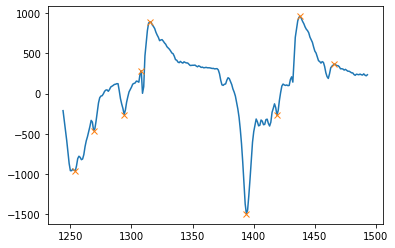

In [207]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log.left1.iloc[pos1:pos2])
plt.plot(peaks_l1+pos1, log.left1[peaks_l1+pos1], "x")

In [208]:
end=starttime+ timedelta(0,seconds=anchor_e_front)
logtimes=log['absTime'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
pos3 = (np.abs(logtimes-end)).argmin()
print(end,pos3,logtimes[pos3])

2020-07-08 21:13:01.920000 24808 2020-07-08 21:13:01.928000


In [209]:
pos4 = (np.abs(logtimes-(end+allowance))).argmin()
print(pos4,logtimes[pos4])

25058 2020-07-08 21:13:06.925000


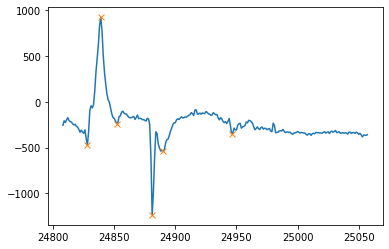

In [210]:
peaks_l1_end, _ = find_peaks(log.left1.iloc[pos3:pos4].abs(), prominence=(100,None),width=1)
plt.plot(log.left1.iloc[pos3:pos4])
plt.plot(peaks_l1_end+pos3, log.left1[peaks_l1_end+pos3], "x")

In [211]:
peaks_l1_end+pos3

array([24828, 24839, 24852, 24881, 24890, 24946])

In [212]:
duration= timedelta(0,seconds=anchor_e_front)-timedelta(0,seconds=anchor_s_front)
duration

datetime.timedelta(0, 471, 320000)

In [213]:
logtimes[peaks_l1[:]+pos1]+duration

1254   2020-07-08 21:13:02.122
1269   2020-07-08 21:13:02.422
1294   2020-07-08 21:13:02.917
1308   2020-07-08 21:13:03.202
1315   2020-07-08 21:13:03.336
1394   2020-07-08 21:13:04.921
1419   2020-07-08 21:13:05.422
1438   2020-07-08 21:13:05.797
1466   2020-07-08 21:13:06.359
Name: absTime, dtype: datetime64[ns]

In [214]:
logtimes[peaks_l1_end[:]+pos3]

24828   2020-07-08 21:13:02.326
24839   2020-07-08 21:13:02.543
24852   2020-07-08 21:13:02.806
24881   2020-07-08 21:13:03.382
24890   2020-07-08 21:13:03.563
24946   2020-07-08 21:13:04.691
Name: absTime, dtype: datetime64[ns]

In [215]:
end_peak = np.array(logtimes[peaks_l1_end[:]+pos3])
cal_end_peak = np.array(logtimes[peaks_l1[:]+pos1]+duration)

In [216]:
def closest_node(points, nodes):
    value_list=[]
    for p in points:
        ind=(np.abs(p-nodes)).argmin()
        value=nodes[ind]
        value_list.append(value)
    index=(np.abs(value_list-points)).argmin()
    point=points[index]
    return index, point

In [217]:
i,point=closest_node(cal_end_peak,end_peak)

manual change to first peak

i=0
point=cal_end_peak[i]

check the index

In [239]:
print(i,cal_end_peak[i],point)

0 2020-07-08T21:13:02.122000000 2020-07-08T21:13:02.122000000


 anchor start from:

In [240]:
logtimes[peaks_l1[i]+pos1]

Timestamp('2020-07-08 21:05:10.802000')

and end at about:

In [241]:
logtimes[peaks_l1[i]+pos1]+duration

Timestamp('2020-07-08 21:13:02.122000')

which is the approximate timestamp regarding the detected peak at:

In [242]:
ind=(np.abs(point-end_peak)).argmin()
end_peak[ind]
#logtimes[peaks_l1_end[2]+pos3]

numpy.datetime64('2020-07-08T21:13:02.326000000')



so in log data the valid anchor record is most surely at that point 

check in the plot again

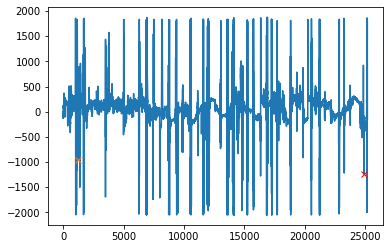

In [243]:
peaks_l1, _ = find_peaks(log.left1.iloc[pos1:pos4].abs(), prominence=(100,None),width=1)
plt.plot(log.left1)
plt.plot(peaks_l1[i]+pos1, log.left1[peaks_l1[i]+pos1], "x")
plt.plot(peaks_l1[-3]+pos1, log.left1[peaks_l1[-3]+pos1], "rx")

In [244]:
#change the date time into timestamp
# start_timestamp = datetime.timestamp(starttime)

find the positions where anchor start and end point in annotation dateframe

In [245]:
anchor_s_end_ind=anno[anno.anchor==1].index[-1]+1
anchor_s_end_ind

746

In [246]:
anchor_e_front_ind=anno[anno.anchor==2].index[0]
anchor_e_front_ind

12323

In [247]:
anchor_e_log_ind=np.abs(logtimes-point).argmin()
anchor_e_log_ind

24818

In [248]:
span = timedelta(0,seconds=anchor_s_end)-timedelta(0,seconds=anchor_s_front)

In [249]:
anchor_s_log_ind=np.abs(logtimes-(logtimes[peaks_l1[i]+pos1]+span)).argmin()
anchor_s_log_ind

1664

In [250]:
peaks_l1[i]+pos1

1254

In [251]:
 log.absTime[anchor_e_log_ind]

'2020-07-08 21:13:02.124000'

In [252]:
 
checkpoints = log.absTime[anchor_s_log_ind:anchor_e_log_ind].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
nodes = np.array([timedelta(seconds=anno.timeAfterStart[j])+starttime for j in range(anchor_s_end_ind,anchor_e_front_ind)])

In [253]:
print(checkpoints[:5])

print(type(checkpoints))

1664   2020-07-08 21:05:19.003
1665   2020-07-08 21:05:19.023
1666   2020-07-08 21:05:19.037
1667   2020-07-08 21:05:19.061
1668   2020-07-08 21:05:19.082
Name: absTime, dtype: datetime64[ns]
<class 'pandas.core.series.Series'>


In [254]:
print(nodes)
print(type(nodes[0]))

[datetime.datetime(2020, 7, 8, 21, 5, 18, 840000)
 datetime.datetime(2020, 7, 8, 21, 5, 18, 880000)
 datetime.datetime(2020, 7, 8, 21, 5, 18, 920000) ...
 datetime.datetime(2020, 7, 8, 21, 13, 1, 800000)
 datetime.datetime(2020, 7, 8, 21, 13, 1, 840000)
 datetime.datetime(2020, 7, 8, 21, 13, 1, 880000)]
<class 'datetime.datetime'>


In [255]:
checkpoints.index

RangeIndex(start=1664, stop=24818, step=1)

In [256]:
data_bilabel=log.iloc[checkpoints.index[0]:checkpoints.index[-1]+1].copy()
label_l=[]
for i,p in enumerate(checkpoints):
    ind=np.abs(p-nodes[max(round(i/2)-10,0):min(round(i/2)+10,anchor_e_front_ind)]).argmin()
    label=anno.label[anchor_s_end_ind+ind+max(round(i/2)-10,0)]
    label_l.append(label)
data_bilabel['label']=label_l


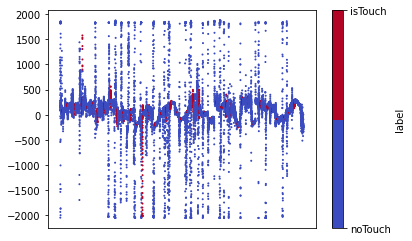

In [259]:
plt.figure()
#color= ['red' if l == 0 else 'green' for l in data_bilabel.label[700:1800]]
plt.scatter(data_bilabel.absTime, data_bilabel.left1,s=1, c=data_bilabel.label, cmap=plt.cm.get_cmap('coolwarm', 2))
plt.gca().set_xticks([])
cbar=plt.colorbar(ticks=range(2), label='label')
cbar.ax.set_yticklabels(['noTouch',  'isTouch'])
plt.show()


In [ ]:
def export_to_csv(dataset, path):
    dataset.to_csv(path, index = False, header=True, sep=';')
    return 'exported successfully'

In [187]:
file_new_paths = '../data/processed/'

In [188]:
text[0]

'20200703_13_20_20'

In [189]:
export_to_csv(data_bilabel, file_new_paths+'bilabel_'+text[0]+'.csv')

'exported successfully'

# plot the data to check anchor label



In [ ]:
data= data_list[0]
data.head()

In [ ]:
data_l1=data['left1']
data_r1=data['right2']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
from scipy.signal import argrelextrema,find_peaks_cwt
peaks_l1, _ = find_peaks(data_l1.abs(), prominence=(200,None),width=1)
peaks_r1, _ = find_peaks(data_r1.abs(), prominence=(200,None),width=1)
plt.subplot(211)
plt.plot(data_l1)
plt.plot(peaks_l1, data_l1[peaks_l1], "x")
plt.subplot(212)
plt.plot(data_r1)
plt.plot(peaks_r1, data_r1[peaks_r1], "x")

In [ ]:
import matplotlib
dates = data['#timestamp']
plt.plot(dates.head(2000),data_r1.head(2000))
plt.gca().set_xticks([])
plt.plot(peaks_r1[:19], data_r1[peaks_r1[:19]], "x")
plt.xticks([dates[peaks_r1[0]],dates[peaks_r1[16]]],rotation=45)

In [ ]:
plt.plot(data_r1.tail(600))
plt.plot(peaks_r1[-10:], data_r1[peaks_r1[-10:]], "x")

In [ ]:

plt.plot(dates.tail(1000),data_l1.tail(1000))
plt.gca().set_xticks([])
plt.plot(dates[peaks_l1[-65:]], data_l1[peaks_l1[-65:]], "x")
plt.xticks([dates[peaks_l1[-65]], dates[peaks_l1[-33]]],rotation=45)


In [ ]:
dlabel= label_list[0]
dlabel.head()

In [ ]:
frist_touch =  dlabel[dlabel.anchor==1].timeAfterStart.head(1).item()
frist_touch

In [ ]:
last_touch =  dlabel[dlabel.anchor==1].timeAfterStart.tail(1).item()
last_touch

In [ ]:
frist_touchend =  dlabel[dlabel.anchor==2].timeAfterStart.head(1).item()
frist_touchend

In [ ]:
last_touchend =  dlabel[dlabel.anchor==2].timeAfterStart.tail(1).item()
last_touchend

In [ ]:
import glob
file_paths = '../data/raw/'
labelfilenames = glob.glob(file_paths+"*.txt",recursive = True)
labelfilenames[0]

In [ ]:
import re
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
text = re.findall('[0-9]+_[0-9]+_[0-9]+_[0-9]+', labelfilenames[0])

starttime=datetime.strptime(text[0],'%Y%m%d_%H_%M_%S')
starttime

In [ ]:
span = timedelta(0,seconds=frist_touch)
print(span)
startstamp = starttime+span
startstamp.strftime('%Y-%m-%d %H:%M:%S.%f')


In [ ]:
span = timedelta(0,seconds=last_touch)
print(span)
startstamp = starttime+span
startstamp.strftime('%Y-%m-%d %H:%M:%S.%f')

In [ ]:
spanend = timedelta(0,seconds=frist_touchend)
endstamp = starttime+spanend
endstamp.strftime('%Y-%m-%d %H:%M:%S.%f')

In [ ]:
spanend = timedelta(0,seconds=last_touchend)
endstamp = starttime+spanend
endstamp.strftime('%Y-%m-%d %H:%M:%S.%f')

In [ ]:
duration=frist_touchend-frist_touch
dur=timedelta(0,seconds = -duration)
endtime=datetime.strptime(dates[peaks_r1[-35]],'%Y-%m-%d %H:%M:%S.%f')
adj_startstamp=endtime+dur
str(adj_startstamp)